In [ ]:
!pip install yfinance
!pip install yahoo_fin

In [ ]:
# In[Imports]

import yfinance as yf
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from yahoo_fin import stock_info as si
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import os
import matplotlib.pyplot as plt


In [ ]:
# Tensorflow's latest update screwed up GPU compatibility, so this part is needed.
# If no GPUs found, it'll ignore this part.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Seeds are the same so it gives the same result every run
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


1 Physical GPUs, 1 Logical GPUs


In [ ]:
# In[Parameters]

#define the ticker symbol
ticker_symbols = ['TSLA','GOOG','AMZN','AAPL']

#number of days
window_size = 100

#split ratio points of dataset
train_stop = 0.7
test_start = 0.9

#number of training cycles/iterations
epoch = 200

#early staopping trigger
wait = 20

#training cycles before weights are updated
batch = 256

#how many epochs between checking validation data
val_freq = 1

#classification or regression
classification = False

#percent change margin
buy_margin = 0.03
sell_margin = 0.01


In [ ]:
# In[Create DataFrame]

df_dict = {}
for symbol in ticker_symbols:
    #get data on each ticker
    ticker_data = yf.Ticker(symbol)
    
    #get the historical prices for each ticker
    df_dict[symbol] = ticker_data.history(period='1d', start='2010-1-1', end='2021-1-1')

#make dataframe
data = pd.concat(df_dict, axis = 1)

#replace nans with zeros
data = data.fillna(0)


In [ ]:
# In[Create Targets]

target = {}
for i in range(data.shape[0] - 1):
    closes = []
    for ticker in ticker_symbols:
        closes.append(data[(ticker, 'Close')][i + 1])
    target[data.index[i]] = closes

#create dataframe of targets
target = pd.DataFrame.from_dict(target ,orient = 'index', columns = ticker_symbols)

#make targets classes
if classification:
    for i in range(data.shape[0] - 1):
        for ticker in ticker_symbols:
            final = target[ticker][i]
            initial = data[(ticker, 'Close')][i]
            if initial == 0:
                initial = 0.000001
            if ((final - initial) / initial) >= buy_margin:
                target[ticker][i] = 0  #BUY
            elif ((final - initial) / initial) <= sell_margin:
                target[ticker][i] = 1  #SELL
            else:
                target[ticker][i] = 2  #HOLD

#drop last day, since we don't know the closing for tomorrow
data = data[: -1]

#data["date"] = data.index
#target["date"] = target.index

print(data)
print(target)

                  TSLA              ...      AAPL             
                  Open        High  ... Dividends Stock Splits
Date                                ...                       
2010-01-04    0.000000    0.000000  ...       0.0          0.0
2010-01-05    0.000000    0.000000  ...       0.0          0.0
2010-01-06    0.000000    0.000000  ...       0.0          0.0
2010-01-07    0.000000    0.000000  ...       0.0          0.0
2010-01-08    0.000000    0.000000  ...       0.0          0.0
...                ...         ...  ...       ...          ...
2020-12-23  632.200012  651.500000  ...       0.0          0.0
2020-12-24  642.989990  666.090027  ...       0.0          0.0
2020-12-28  674.510010  681.400024  ...       0.0          0.0
2020-12-29  661.000000  669.900024  ...       0.0          0.0
2020-12-30  672.000000  696.599976  ...       0.0          0.0

[2768 rows x 28 columns]
                  TSLA         GOOG         AMZN        AAPL
2010-01-04    0.000000   310.82

In [ ]:
# In[Normalize Data]

n = len(data)

scaler = MinMaxScaler()
scaler.fit(data[0 : int(n * train_stop)])
scaled_data = scaler.transform(data)

scaler_target = MinMaxScaler()
scaler_target.fit(target[0 : int(n * train_stop)])
target = scaler_target.transform(target)

print(pd.DataFrame(scaled_data))
print(pd.DataFrame(target))

            0         1         2         3   ...        24        25   26   27
0     0.000000  0.000000  0.000000  0.000000  ...  0.020251  0.244034  0.0  0.0
1     0.000000  0.000000  0.000000  0.000000  ...  0.020592  0.302982  0.0  0.0
2     0.000000  0.000000  0.000000  0.000000  ...  0.017448  0.275875  0.0  0.0
3     0.000000  0.000000  0.000000  0.000000  ...  0.017088  0.234989  0.0  0.0
4     0.000000  0.000000  0.000000  0.000000  ...  0.018379  0.218903  0.0  0.0
...        ...       ...       ...       ...  ...       ...       ...  ...  ...
2763  8.174507  8.417530  8.205746  8.423262  ...  3.742832  0.023062  0.0  0.0
2764  8.314024  8.606036  8.448662  8.629156  ...  3.773063  0.004919  0.0  0.0
2765  8.721586  8.803845  8.709634  8.654192  ...  3.914344  0.042822  0.0  0.0
2766  8.546898  8.655262  8.633188  8.684183  ...  3.859867  0.040948  0.0  0.0
2767  8.689131  9.000232  8.809279  9.059591  ...  3.825445  0.027545  0.0  0.0

[2768 rows x 28 columns]
             0

In [ ]:
# In[Create Windows]

x = []
y = []

#goes from end of first window to end of data
for i in range(window_size, scaled_data.shape[0]):
    x.append(scaled_data[i - window_size : i])
    y.append(target[i : i + 1])
    
x = np.array(x)
y = np.array(y)

print(x)
print(y)

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.44034312e-01
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.02982342e-01
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.75874854e-01
   0.00000000e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.85993876e-01
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.46076976e-01
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.38533516e-01
   0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.02982342e-01
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.75874854e-01
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.34989328e-01
   0.00000000e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.46076976e-01
   0.00000

In [ ]:
# In[Split Data]

#same names of labels
#data_column_indices = {name : i for i, name in enumerate(scaled_data.columns)}
#target_column_indices = {name : i for i, name in enumerate(scaled_target.columns)}

n = x.shape[0]

x_train = x[0 : int(n * train_stop)]
x_val = x[int(n * train_stop) : int(n * test_start)]
x_test = x[int(n * test_start) :]

y_train = y[0 : int(n * train_stop)]
y_val = y[int(n * train_stop) : int(n * test_start)]
y_test = y[int(n * test_start) :]

num_features = scaled_data.shape[1]


In [ ]:
# In[Sklearn Testing]
'''
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

sk_x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
sk_y_train = y_train.reshape(y_train.shape[0] * y_train.shape[1] * y_train.shape[2])
sk_x_val = x_val.reshape(x_val.shape[0], x_val.shape[1] * x_val.shape[2])
sk_y_val = y_val.reshape(y_val.shape[0] * y_val.shape[1] * y_val.shape[2])

#clf = SVC(C = 10, kernel = 'rbf', verbose = True)
#clf = RandomForestClassifier(max_depth = 3, random_state = 0)
#clf = KNeighborsClassifier(n_neighbors = 500)
#clf = AdaBoostClassifier()
#clf = GaussianNB()
#clf = QuadraticDiscriminantAnalysis()
clf = MLPClassifier(
                    alpha = 0.1, 
                    activation = 'tanh',
                    solver = 'adam',
                    hidden_layer_sizes = (10000, 5), 
                    max_iter = 1000, 
                    verbose = True
                   )

clf.fit(sk_x_train, sk_y_train)

print(clf.score(sk_x_val, sk_y_val))

#print(sk_x_train.shape)
#print(sk_y_train.shape)
'''

"\nfrom sklearn.svm import SVC\nfrom sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.naive_bayes import GaussianNB\nfrom sklearn.neural_network import MLPClassifier\nfrom sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis\n\nsk_x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])\nsk_y_train = y_train.reshape(y_train.shape[0] * y_train.shape[1] * y_train.shape[2])\nsk_x_val = x_val.reshape(x_val.shape[0], x_val.shape[1] * x_val.shape[2])\nsk_y_val = y_val.reshape(y_val.shape[0] * y_val.shape[1] * y_val.shape[2])\n\n#clf = SVC(C = 10, kernel = 'rbf', verbose = True)\n#clf = RandomForestClassifier(max_depth = 3, random_state = 0)\n#clf = KNeighborsClassifier(n_neighbors = 500)\n#clf = AdaBoostClassifier()\n#clf = GaussianNB()\n#clf = QuadraticDiscriminantAnalysis()\nclf = MLPClassifier(\n                    alpha = 0.1, \n                    activation = 'tanh'

In [ ]:
# In[Create Model]

model = Sequential([
                    LSTM(units = 512, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])),
                    Dropout(0.4),
                          
                    LSTM(units = 512, return_sequences = True),
                    #Bidirectional(LSTM(units = 32, return_sequences = True)),
                    Dropout(0.4),
                    
                    LSTM(units = 512, return_sequences = True),
                    #Bidirectional(LSTM(units = 32, return_sequences = True)),
                    Dropout(0.4),
                          
                    #Bidirectional(LSTM(units = 32, return_sequences = True)),
                    #Dropout(0.4),
                          
                    LSTM(units = 512, return_sequences = False),
                    Dropout(0.4),
                          
                    Dense(units = len(ticker_symbols), activation='linear')
                   ])

model.compile(
              loss = 'mse',
              #loss = 'categorical_crossentropy',
              optimizer = RMSprop(learning_rate = 1e-4),
              metrics = ['mae']
              #metrics = ['accuracy']
             )

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 512)          1107968   
_________________________________________________________________
dropout (Dropout)            (None, 100, 512)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 512)          2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2

In [ ]:
# In[Train Model]

history = model.fit(
                    x = x_train,
                    y = y_train,
                    epochs = epoch,
                    batch_size = batch,
                    shuffle = False,
                    validation_data = (x_val, y_val),
                    validation_freq = val_freq,
                    #callbacks = [EarlyStopping(patience = wait)]
                   )


Epoch 1/200
8/8 [==============================] - 12s 578ms/step - loss: 0.0294 - mae: 0.1212 - val_loss: 0.2553 - val_mae: 0.3922
Epoch 2/200
8/8 [==============================] - 3s 390ms/step - loss: 0.0200 - mae: 0.1054 - val_loss: 0.1163 - val_mae: 0.2639
Epoch 3/200
8/8 [==============================] - 3s 394ms/step - loss: 0.0117 - mae: 0.0838 - val_loss: 0.4777 - val_mae: 0.5985
Epoch 4/200
8/8 [==============================] - 3s 399ms/step - loss: 0.0113 - mae: 0.0704 - val_loss: 0.1622 - val_mae: 0.3155
Epoch 5/200
8/8 [==============================] - 3s 401ms/step - loss: 0.0121 - mae: 0.0873 - val_loss: 0.4520 - val_mae: 0.6019
Epoch 6/200
8/8 [==============================] - 3s 404ms/step - loss: 0.0101 - mae: 0.0663 - val_loss: 0.1690 - val_mae: 0.3449
Epoch 7/200
8/8 [==============================] - 3s 401ms/step - loss: 0.0123 - mae: 0.0916 - val_loss: 0.3344 - val_mae: 0.4927
Epoch 8/200
8/8 [==============================] - 3s 395ms/step - loss: 0.0082 - 

In [ ]:
# In[Test Model]

model.evaluate(
               x = x_test,
               y = y_test
              )

y_pred = model.predict(x_test)


9/9 [==============================] - 0s 27ms/step - loss: 3.8902 - mae: 1.3318


In [ ]:
print(y_test.reshape(y_test.shape[0], y_test.shape[2]))

[[0.919807   1.47144067 1.73705492 1.83173964]
 [0.9380101  1.47829034 1.74935116 1.83685924]
 [0.93464597 1.47510679 1.7499972  1.86423498]
 ...
 [8.68418267 2.01119537 3.40332966 3.85986688]
 [9.05959065 1.98614518 3.36504298 3.82544468]
 [9.2015903  2.00227126 3.33441338 3.79461456]]


In [ ]:
print(y_pred)

[[1.2326541 1.2867203 1.3783003 1.3632864]
 [1.2331673 1.2871279 1.3787217 1.36369  ]
 [1.2337431 1.2875853 1.3791751 1.3641452]
 ...
 [1.1726344 1.1665826 1.1810685 1.2237656]
 [1.1733575 1.1665465 1.1803753 1.2238681]
 [1.1744012 1.1668217 1.1801256 1.2244097]]


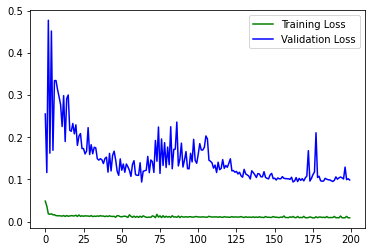

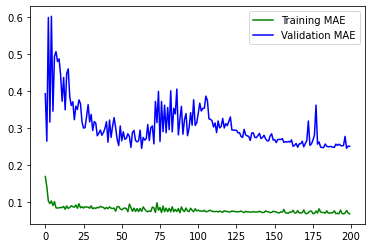

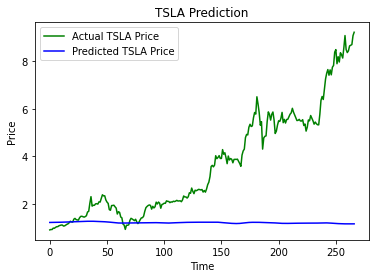

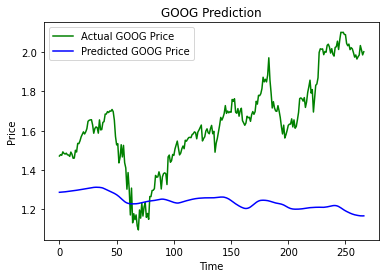

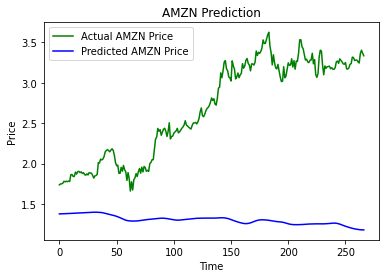

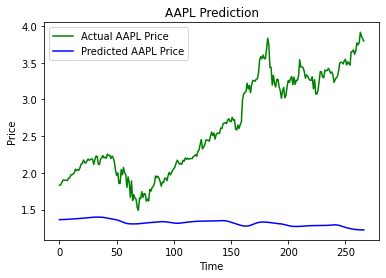

In [ ]:
# In[Graph Results]

#plot loss
plt.plot(
         history.history['loss'],
         label = 'Training Loss',
         color = 'green',
         linestyle = 'solid'
        )

plt.plot(
         history.history['val_loss'],
         label = 'Validation Loss',
         color = 'blue',
         linestyle = 'solid'
        )

plt.legend()
plt.show()

#plot accuracy
plt.plot(

         history.history['mae'],
         label = 'Training MAE',
         color = 'green',
         linestyle = 'solid'
        )

plt.plot(
         history.history['val_mae'],
         label = 'Validation MAE',
         color = 'blue',
         linestyle = 'solid'
        )

plt.legend()
plt.show()


#plot stock predictions
y_test_2d = y_test.reshape(y_test.shape[0], y_test.shape[2])
y_pred = np.array(y_pred)

for i in range(len(ticker_symbols)):
    plt.plot(y_test_2d[:, i], color = 'green', label = 'Actual ' + ticker_symbols[i] + ' Price')
    plt.plot(y_pred[:, i], color = 'blue', label = 'Predicted ' + ticker_symbols[i] + ' Price')
    plt.title(ticker_symbols[i] + ' Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [ ]:
def shuffle_dataset(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)


In [ ]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    
    # Loads data from Yahoo Finance, shuffles, scales
    
    # See if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # Container for the results
    result = {}
    # Return original df
    result['df'] = df.copy()
    # Make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # Add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # Scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # Add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # Add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # Last `lookup_step` columns contains NaN in future column
    # Get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # Drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # Get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # For instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # This last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # Construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # Split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # Shuffle the datasets for training (if shuffle parameter is set)
            shuffle_dataset(result["X_train"], result["y_train"])
            shuffle_dataset(result["X_test"], result["y_test"])
    else:    
        # Split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # Get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # Retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # Remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # Remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result


In [ ]:
# Build the model here

# Sequence length: Time as steps in days for the tickers
# n_features: Number of features passed. Here it'll be 5 since we're passing
# adjclose, open, high, low, volume
# Units: RNN cell units
# Bidirectional: BOOL value of whether the RNN is bidirectional or not

def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mae"], optimizer=optimizer)
    return model


In [ ]:
# Window size or the sequence length
N_STEPS = 100
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 4
# LSTM cell
CELL = LSTM
# LSTM neurons
UNITS = 512
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
LOSS = "mse"
OPTIMIZER = "adam"
BATCH_SIZE = 256
EPOCHS = 200
# TSLA stock ticker
ticker = "TSLA"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")

# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"


In [ ]:
# create these folders if they does not exist
# Pass is there because my IDE freaks out if its not after an if statement.
# Idk why, I'll keep it there.
if not os.path.isdir("results"):
    os.mkdir("results")
    pass
if not os.path.isdir("logs"):
    os.mkdir("logs")
    pass
if not os.path.isdir("data"):
    os.mkdir("data")
    pass


In [ ]:
# Calls above functions to run the trainer:

# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)


Epoch 1/200
9/9 [==============================] - 9s 589ms/step - loss: 0.0368 - mae: 0.0999 - val_loss: 0.0018 - val_mae: 0.0317

Epoch 00001: val_loss improved from inf to 0.00184, saving model to results/2021-04-10_TSLA-sh-1-sc-1-sbd-0-mse-adam-LSTM-seq-100-step-1-layers-4-units-512.h5
Epoch 2/200
9/9 [==============================] - 3s 365ms/step - loss: 0.0034 - mae: 0.0328 - val_loss: 0.0047 - val_mae: 0.0314

Epoch 00002: val_loss did not improve from 0.00184
Epoch 3/200
9/9 [==============================] - 3s 366ms/step - loss: 0.0033 - mae: 0.0324 - val_loss: 6.0023e-04 - val_mae: 0.0188

Epoch 00003: val_loss improved from 0.00184 to 0.00060, saving model to results/2021-04-10_TSLA-sh-1-sc-1-sbd-0-mse-adam-LSTM-seq-100-step-1-layers-4-units-512.h5
Epoch 4/200
9/9 [==============================] - 3s 370ms/step - loss: 0.0019 - mae: 0.0227 - val_loss: 4.8584e-04 - val_mae: 0.0142

Epoch 00004: val_loss improved from 0.00060 to 0.00049, saving model to results/2021-04-10_

In [ ]:
# Makes predictions
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [ ]:
# Takes model and data and merges into a final dataframe.
# Dataframe includes the features that were in model and data
# So it has real values and predicted values of the test set
def get_final_df(model, data):
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    return final_df


In [ ]:
# Plots true price and predicted prices
def plot_graph(test_df):
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

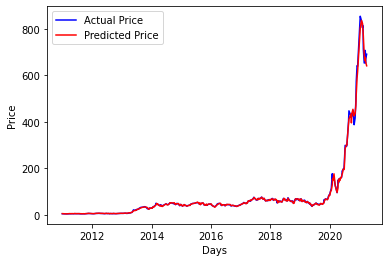

                  open        high  ...  adjclose_1  true_adjclose_1
2021-02-11  812.440002  829.880005  ...  805.340088       816.119995
2021-02-16  818.000000  821.000000  ...  788.234192       798.150024
2021-02-19  795.000000  796.789978  ...  770.696350       714.500000
2021-03-02  718.280029  721.109985  ...  687.507935       653.200012
2021-03-12  670.000000  694.880005  ...  663.797241       707.940002
2021-03-16  703.349976  707.919983  ...  677.637573       701.809998
2021-03-17  656.869995  703.729980  ...  675.100098       653.159973
2021-03-18  684.289978  689.229980  ...  669.074402       654.869995
2021-03-19  646.599976  657.229980  ...  659.639221       670.000000
2021-04-01  688.369995  692.419983  ...  641.378052       691.049988

[10 rows x 9 columns]


In [ ]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)

if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

# get the final dataframe for the testing set
final_df = get_final_df(model, data)

# predict the future price
future_price = predict(model, data)

# plot true/pred prices graph
plot_graph(final_df)

print(final_df.tail(10))

# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)


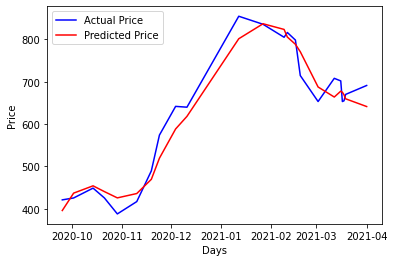

In [ ]:
# Plots true price and predicted prices
def plot_graph(test_df):
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'][500:], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'][500:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

plot_graph(final_df)

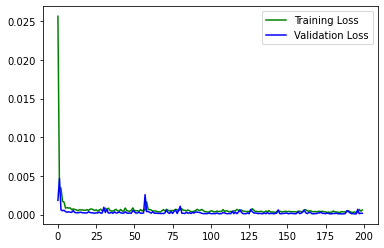

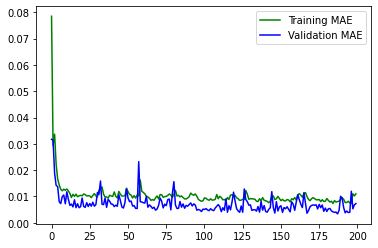

In [ ]:
# In[Graph Results]

#plot loss
plt.plot(
         history.history['loss'],
         label = 'Training Loss',
         color = 'green',
         linestyle = 'solid'
        )

plt.plot(
         history.history['val_loss'],
         label = 'Validation Loss',
         color = 'blue',
         linestyle = 'solid'
        )

plt.legend()
plt.show()

#plot accuracy
plt.plot(

         history.history['mae'],
         label = 'Training MAE',
         color = 'green',
         linestyle = 'solid'
        )

plt.plot(
         history.history['val_mae'],
         label = 'Validation MAE',
         color = 'blue',
         linestyle = 'solid'
        )

plt.legend()
plt.show()


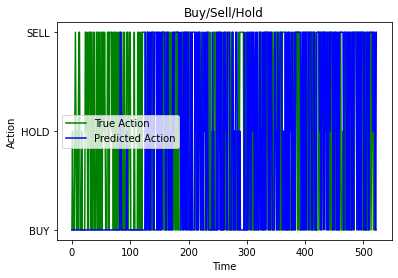


Accuracy = 0.4225621414913958
True Ratio = 221 / 523 

      Precision    Recall  F1-Score
BUY    0.491039  0.535156  0.512150
SELL   0.048780  0.042553  0.045455
HOLD   0.403941  0.372727  0.387707

Confusion Matix:
       BUY  SELL  HOLD
BUY   137    20    99
SELL   23     2    22
HOLD  119    19    82 

---------------------------------------------



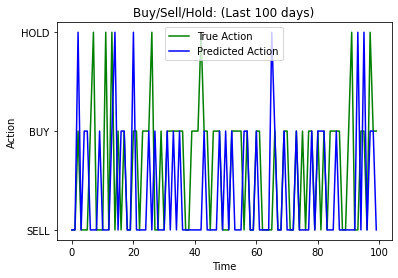


Accuracy = 0.51
True Ratio = 51 / 100 

      Precision    Recall  F1-Score
BUY    0.642857  0.367347  0.467532
SELL   0.000000  0.000000  0.000000
HOLD   0.500000  0.750000  0.600000

Confusion Matix:
       BUY  SELL  HOLD
BUY    18     3    28
SELL    2     0     5
HOLD    8     3    33 

---------------------------------------------



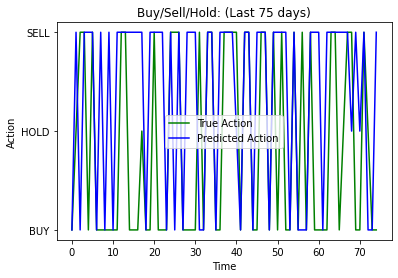


Accuracy = 0.5466666666666666
True Ratio = 41 / 75 

      Precision    Recall  F1-Score
BUY    0.772727  0.414634  0.539683
SELL   0.000000  0.000000  0.000000
HOLD   0.480000  0.800000  0.600000

Confusion Matix:
       BUY  SELL  HOLD
BUY    17     1    23
SELL    1     0     3
HOLD    4     2    24 

---------------------------------------------



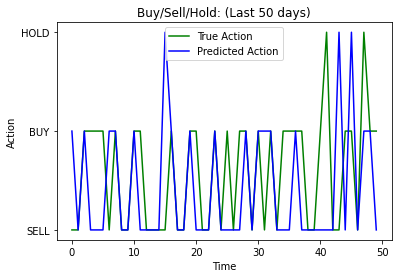


Accuracy = 0.58
True Ratio = 29 / 50 

      Precision    Recall  F1-Score
BUY    0.733333  0.440000  0.550000
SELL   0.000000  0.000000  0.000000
HOLD   0.562500  0.782609  0.654545

Confusion Matix:
       BUY  SELL  HOLD
BUY    11     1    13
SELL    1     0     1
HOLD    3     2    18 

---------------------------------------------



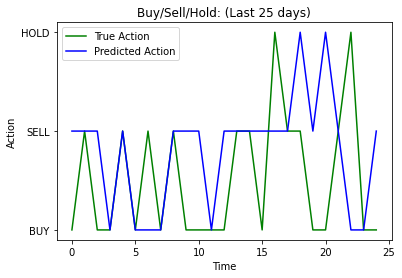


Accuracy = 0.48
True Ratio = 12 / 25 

      Precision    Recall  F1-Score
BUY    0.714286  0.357143   0.47619
SELL   0.000000  0.000000   0.00000
HOLD   0.437500  0.777778   0.56000

Confusion Matix:
       BUY  SELL  HOLD
BUY     5     1     8
SELL    1     0     1
HOLD    1     1     7 

---------------------------------------------



In [ ]:
# In[Buy/Sell/Hold]

#percent change margin
buy_margin = 0.003   #should be positive
sell_margin = -0.003  #should be negative

# buy/sell/hold
def buy_sell(initial, final):
    if initial == 0:
        initial = 0.000001
    if ((final - initial) / initial) >= buy_margin:
        return 'BUY'  #BUY
    elif ((final - initial) / initial) <= sell_margin:
        return 'SELL'  #SELL
    else:
        return 'HOLD'  #HOLD

#get classification
true_action = []
pred_action = []
for index, row in final_df.iterrows():
    true_action.append(buy_sell(initial = row['adjclose'], final = row['true_adjclose_1']))
    pred_action.append(buy_sell(initial = row['adjclose'], final = row['adjclose_1']))

# plot buy/sell/hold predictions verus truth
def info_buy_sell(truth, prediction, num_days = 0):
    plt.plot(
             truth[(-1 * num_days):],
             label = 'True Action',
            color = 'green',
            linestyle = 'solid'
            )

    plt.plot(
            prediction[(-1 * num_days):],
            label = 'Predicted Action',
            color = 'blue',
            linestyle = 'solid'
            )
    if num_days == 0:
        plt.title('Buy/Sell/Hold')
    else:
        plt.title('Buy/Sell/Hold: (Last ' + str(num_days) + ' days)')
    plt.xlabel('Time')
    plt.ylabel('Action')
    plt.legend()
    plt.show()

    print('\nAccuracy =', accuracy_score(true_action[(-1 * num_days):], pred_action[(-1 * num_days):]))
    print('True Ratio =', accuracy_score(true_action[(-1 * num_days):], pred_action[(-1 * num_days):], normalize = False), '/', len(true_action[(-1 * num_days):]), '\n')

    print(pd.DataFrame(
                    data = {
                            'Precision':precision_score(true_action[(-1 * num_days):], pred_action[(-1 * num_days):], average = None),
                            'Recall':recall_score(true_action[(-1 * num_days):], pred_action[(-1 * num_days):], average = None),
                            'F1-Score':f1_score(true_action[(-1 * num_days):], pred_action[(-1 * num_days):], average = None)
                            },
                    index = ['BUY', 'SELL', 'HOLD']
                    ))

    print('\nConfusion Matix:\n', pd.DataFrame(
                                                data = confusion_matrix(true_action[(-1 * num_days):], pred_action[(-1 * num_days):]),
                                                index = ['BUY', 'SELL', 'HOLD'],
                                                columns = ['BUY', 'SELL', 'HOLD']
                                              ), '\n')
    print('---------------------------------------------\n')

# print accuracy and plots
info_buy_sell(truth = true_action, prediction = pred_action)
info_buy_sell(truth = true_action, prediction = pred_action, num_days = 100)
info_buy_sell(truth = true_action, prediction = pred_action, num_days = 75)
info_buy_sell(truth = true_action, prediction = pred_action, num_days = 50)
info_buy_sell(truth = true_action, prediction = pred_action, num_days = 25)


In [ ]:
# In[Print Values]

for i in zip(true_action, pred_action):
    print('True', i, 'Prediction')


True ('HOLD', 'BUY') Prediction
True ('HOLD', 'BUY') Prediction
True ('HOLD', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('HOLD', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('HOLD', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('HOLD', 'BUY') Prediction
True ('HOLD', 'BUY') Prediction
True ('HOLD', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('HOLD', 'BUY') Prediction
True ('HOLD', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('HOLD', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('HOLD', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('HOLD', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('BUY', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('SELL', 'BUY') Prediction
True ('SELL', 'BUY'